In [1]:
import pandas as pd
import glob
import os
import numpy as np
from tqdm import tqdm
import re

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

import tensorflow as tf
from tensorflow.keras import backend as K

# Initialize session
sess = tf.Session()

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)



In [2]:

labels = {0:'false', 1:'partly true', 2:'true'}


In [4]:

train_df = pd.read_csv('../data/full_train.cvs')
train_df = train_df.sample(frac=.25).reset_index(drop=True)

train_df.tail()

,Unnamed: 0,article,claim,claimant,date,label
19415,50816,medicaid gov medicaid marketplace overview fed...,single mother two qualify basic healthcare med...,Chris Koster,2016-01-20,1
19416,58918,##th amendment constitution direct election se...,fake news media wants speak house midterm resu...,Donald Trump,2018-11-19,0
19417,23492,robert mueller former director named special c...,fbi announced inquiry russian ties trump campa...,NaN,2017-10-27,2
19418,31249,points marco rubio troubled financial history ...,says question financial skills cnbc debate inc...,Marco Rubio,2015-10-28,0
19419,3703,transcripts return transcripts main page state...,president george bush spent trillion tax cuts ...,Donna Brazile,2009-08-02,1


In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils


X = train_df[['claim', 'article']]
y = train_df['label']

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
y = np_utils.to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print("num train: ", X_train.shape)
print("num test: ", y_train.shape)

X_train.tail()

num train:  (14565, 2)
num test:  (14565, 3)


Using TensorFlow backend.


,claim,article
11284,prohibition ended police deaths reach ### year...,scope marijuana use united states marijuana co...
11964,photograph shows hercules world biggest dog se...,## stone dog world heaviest proud owner tom sc...
5390,oil companies obtain acre public land less pri...,fair share companies sit public lands less cup...
860,casey anthony opening home daycare center flor...,false motorcycle curfew ## states march #### s...
15795,governing magazine estimated states expand med...,rural hospitals life support story part specia...


In [7]:
from nltk.corpus import stopwords as sw
from keras.preprocessing.text import Tokenizer
import string
from keras.preprocessing.sequence import pad_sequences


MAX_NB_WORDS = 100000
max_seq_len = 300
label_names = ["true", "almost", "false"]

num_classes = len(label_names)

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)

tokenizer.fit_on_texts(X_train['claim'].tolist() + X_train['article'].tolist() )

train_claim_seq   = tokenizer.texts_to_sequences(X_train['claim'].tolist())
train_article_seq = tokenizer.texts_to_sequences(X_train['article'].tolist())

test_claim_seq   = tokenizer.texts_to_sequences(X_test['claim'].tolist())
text_article_seq = tokenizer.texts_to_sequences(X_test['article'].tolist())

word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))
nb_words = min(MAX_NB_WORDS, len(word_index)) + 1

#pad sequences
train_claim_seq   = pad_sequences(train_claim_seq, maxlen=max_seq_len)
train_article_seq = pad_sequences(train_article_seq, maxlen=max_seq_len)

test_claim_seq    = pad_sequences(test_claim_seq, maxlen=max_seq_len)
test_article_seq  = pad_sequences(text_article_seq, maxlen=max_seq_len)


tokenizing input data...
dictionary size:  133883


In [8]:
#training params
batch_size = 256 
num_epochs = 4 

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4


In [9]:
#load embeddings
import os, re, csv, math, codecs

print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('/home/sonic/.keras/datasets/wiki-news-300d-1M.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

#embedding matrix
print('preparing embedding matrix...')
words_not_found = []

embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
print("sample words not found: ", np.random.choice(words_not_found, 10))

1521it [00:00, 15199.61it/s]

loading word embeddings...


999995it [01:11, 14043.88it/s]


found 999995 word vectors
preparing embedding matrix...
number of null word embeddings: 36863
sample words not found:  ['mugonyi' 'spendathon' 'hininger' 'gyor' 'nishio' 'oersteds' 'bliley'
 'cutor' 'lepage' 'gualtieri']


In [10]:
from tensorflow import keras
from tensorflow.keras import layers


# num_tags = 12  # Number of unique issue tags
# num_words = 10000  # Size of vocabulary obtained when preprocessing text data
# num_departments = 4  # Number of departments for predictions

claim_input   = keras.Input(shape=(None,), name='claim')    # Variable-length sequence of ints
article_input = keras.Input(shape=(None,), name='article')  # Variable-length sequence of ints

# Embed each word into vector
claim_features   = layers.Embedding(nb_words, embed_dim, weights=[embedding_matrix], 
                                  input_length=max_seq_len, trainable=False, name='claim_emb')(claim_input)
# Embed each word into vector
article_features = layers.Embedding(nb_words, embed_dim, weights=[embedding_matrix], 
                                 input_length=max_seq_len, trainable=False, name='article_emb')(article_input)

# Reduce sequence of embedded words in the title into a single 128-dimensional vector
claim_features = layers.LSTM(128)(claim_features)
# Reduce sequence of embedded words in the body into a single 32-dimensional vector
article_features = layers.LSTM(128)(article_features)

# Merge all available features into a single large vector via concatenation
x = layers.concatenate([claim_features, article_features], name='concat-layer')

# Stick a logistic regression for priority prediction on top of the features
priority_pred = layers.Dense(num_classes, activation='softmax', name='priority')(x)
# Stick a department classifier on top of the features
# department_pred = layers.Dense(num_departments, activation='softmax', name='department')(x)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(inputs=[claim_input, article_input], outputs=[priority_pred], name='fake-model')

model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
              loss='categorical_crossentropy', metrics=['categorical_accuracy'])

keras.utils.plot_model(model, 'multi_input_model.png', show_shapes=True)

model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
claim (InputLayer)              (None, None)         0                                            
__________________________________________________________________________________________________
article (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
claim_emb (Embedding)           (None, None, 300)    30000300    claim[0][0]                      
__________________________________________________________________________________________________
article_emb (Embedding)         (None, None, 300)    30000300    article[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM

In [11]:
#model training

def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)
    
# Instantiate variables
initialize_vars(sess)


hist = model.fit({'claim': train_claim_seq, 'article': train_article_seq},
          y_train,
          epochs=num_epochs, validation_split=0.1,verbose=1,
          batch_size=batch_size)

Train on 13108 samples, validate on 1457 samples
Epoch 1/4
13108/13108 [==============================] - 95s 7ms/sample - loss: 0.9474 - categorical_accuracy: 0.4984 - val_loss: 0.9369 - val_categorical_accuracy: 0.5299
Epoch 2/4
13108/13108 [==============================] - 94s 7ms/sample - loss: 0.9504 - categorical_accuracy: 0.5261 - val_loss: 0.9390 - val_categorical_accuracy: 0.4990
Epoch 3/4
13108/13108 [==============================] - 94s 7ms/sample - loss: 0.9138 - categorical_accuracy: 0.5376 - val_loss: 0.9217 - val_categorical_accuracy: 0.5388
Epoch 4/4
13108/13108 [==============================] - 94s 7ms/sample - loss: 0.8983 - categorical_accuracy: 0.5542 - val_loss: 0.9073 - val_categorical_accuracy: 0.5463


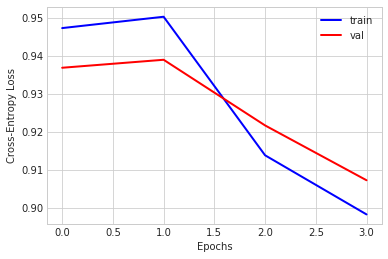

In [12]:
def plot_history(hist):
    #generate plots
    plt.figure()
    plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
    plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
    plt.xlabel('Epochs')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend(loc='upper right')
    plt.show()

#     plt.figure()
#     plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
#     plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
#     plt.xlabel('Epochs')
#     plt.ylabel('Accuracy')
#     plt.legend(loc='upper left')
#     plt.show()

plot_history(hist)

In [13]:
y_pred = model.predict({'claim': test_claim_seq, 'article': test_article_seq})
y_pred

array([[0.5172972 , 0.35597152, 0.12673129],
       [0.26704112, 0.57280797, 0.16015093],
       [0.6122778 , 0.28514203, 0.10258019],
       ...,
       [0.6977874 , 0.2281594 , 0.07405315],
       [0.27420488, 0.36726153, 0.3585336 ],
       [0.4329025 , 0.39273345, 0.17436402]], dtype=float32)

In [14]:
# Results
from sklearn.metrics import f1_score, classification_report

y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)

# Results
print('sklearn Macro-F1-Score:',      f1_score(y_test, y_pred, average='macro'))
print('sklearn Micro-F1-Score:',      f1_score(y_test, y_pred, average='micro'))  
print('sklearn weighted-F1-Score:',   f1_score(y_test, y_pred, average='weighted'))  
print('sklearn no average-F1-Score:', f1_score(y_test, y_pred, average=None))

print(classification_report(y_test, y_pred, target_names=labels.values()))

sklearn Macro-F1-Score: 0.35889201025064926
sklearn Micro-F1-Score: 0.5349124613800206
sklearn weighted-F1-Score: 0.4796355297026243
sklearn no average-F1-Score: [0.65339161 0.37875752 0.0445269 ]
              precision    recall  f1-score   support

       false       0.53      0.84      0.65      2404
 partly true       0.54      0.29      0.38      1941
        true       0.41      0.02      0.04       510

   micro avg       0.53      0.53      0.53      4855
   macro avg       0.50      0.39      0.36      4855
weighted avg       0.52      0.53      0.48      4855



# Gcloud

In [15]:
# Export the model to a local SavedModel directory 
export_path = tf.contrib.saved_model.save_keras_model(model, 'keras_export')
print("Model exported to: ", export_path)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Model exported to:  b'keras_export/1574209457'


In [16]:
# GCloud
! export GOOGLE_APPLICATION_CREDENTIALS="/home/sonic/leadersprize/fakenews-40cea3fac9e2.json"
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/sonic/leadersprize/fakenews-40cea3fac9e2.json'
# %env GOOGLE_APPLICATION_CREDENTIALS '/home/sonic/leadersprize/fakenews-40cea3fac9e2.json'

PROJECT_ID = "fakenews-259222" #@param {type:"string"}
BUCKET_NAME =  PROJECT_ID + "-model" #@param {type:"string"}
REGION = "us-central1" #@param {type:"string"

JOB_NAME = 'my_first_keras_job'
JOB_DIR = 'gs://' + BUCKET_NAME + '/keras-job-dir'

! gcloud config set project $PROJECT_ID
# Explicitly tell `gcloud ai-platform local train` to use Python 3 
! gcloud config set ml_engine/local_python $(which python3)

Updated property [core/project].
Updated property [ml_engine/local_python].


In [17]:
# Only if your bucket doesn't already exist: Run the following cell to create your Cloud Storage bucket.
! gsutil mb -l $REGION gs://$BUCKET_NAME
# ! gsutil acl set -R project-private gs://$BUCKET_NAME
! gsutil ls -al gs://$BUCKET_NAME

Creating gs://fakenews-259222-model/...
ServiceException: 409 Bucket fakenews-259222-model already exists.
                                 gs://fakenews-259222-model/data/


In [19]:
%%time

# Export the model to a SavedModel directory in Cloud Storage
export_path = tf.contrib.saved_model.save_keras_model(model, JOB_DIR + '/keras_export')
print("Model exported to: ", export_path)

Model exported to:  b'gs://fakenews-259222-model/keras-job-dir/keras_export/1574209944'


In [22]:
MODEL_NAME = "my_first_keras_model"
MODEL_VERSION = "v1"

! gcloud ai-platform models create $MODEL_NAME \
  --regions $REGION

Created ml engine model [projects/fakenews-259222/models/my_first_keras_model].


In [ ]:
# Get a list of directories in the `keras_export` parent directory
KERAS_EXPORT_DIRS = ! gsutil ls
print(KERAS_EXPORT_DIRS)

In [23]:
# Get a list of directories in the `keras_export` parent directory
KERAS_EXPORT_DIRS = export_path.decode("utf-8") 
print (KERAS_EXPORT_DIRS)

# Pick the directory with the latest tiAmestamp, in case you've trained
# multiple times
SAVED_MODEL_PATH = KERAS_EXPORT_DIRS

print('saved model path', SAVED_MODEL_PATH)

# Create model version based on that SavedModel directory
! gcloud ai-platform versions create $MODEL_VERSION \
  --model $MODEL_NAME \
  --runtime-version 1.13 \
  --python-version 3.5 \
  --framework tensorflow \
  --origin $SAVED_MODEL_PATH

gs://fakenews-259222-model/keras-job-dir/keras_export/1574209944
saved model path gs://fakenews-259222-model/keras-job-dir/keras_export/1574209944
Creating version (this might take a few minutes)......done.                    


In [58]:
import json
prediction_json = list(zip(test_claim_seq[:2].tolist(), test_article_seq[:2].tolist()))
prediction_json = list(zip(test_claim_seq[:2].tolist(), test_article_seq[:2].tolist()))

# prediction_json = []
# prediction_df = pd.DataFrame(prediction_json)
# prediction_df.to_json('prediction_input.json')

# with open('prediction_input.json', 'w') as json_file:
#     for row in prediction_df.values.tolist():
#         json.dump(row, json_file)
#         json_file.write('\n')

# with open("prediction_input.json", "w") as write_file:
#     json.dump(prediction_json, write_file)


# predict_instance_json = "prediction_input.json"

# with open(predict_instance_json, "wb") as fp:
#         fp.write(json.dumps(prediction_json).encode())
    
i = 1
with open('prediction_input.json', 'w') as json_file:
    for row in prediction_json:
        json.dump({"values": row, "key": i}, json_file)
        json_file.write('\n')
        i +=1
    
! cat prediction_input.json

{"values": [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 198, 82343, 1509, 165, 615, 3681, 2551, 659, 1353, 80, 2850, 26340], [8660, 2067, 1884, 122, 1456, 347, 567, 2145, 73, 479,

In [61]:
! gcloud ai-platform predict \
  --model $MODEL_NAME \
  --version $MODEL_VERSION \
  --json-instances prediction_input.json

{
  "error": "Prediction failed: Unexpected tensor name: values"
}


In [60]:
! gcloud components update

ERROR: (gcloud.components.update) 
You cannot perform this action because the Cloud SDK component manager 
is disabled for this installation. You can run the following command 
to achieve the same result for this installation: 

sudo apt-get update && sudo apt-get --only-upgrade install kubectl google-cloud-sdk google-cloud-sdk-app-engine-grpc google-cloud-sdk-pubsub-emulator google-cloud-sdk-app-engine-go google-cloud-sdk-cloud-build-local google-cloud-sdk-datastore-emulator google-cloud-sdk-app-engine-python google-cloud-sdk-cbt google-cloud-sdk-bigtable-emulator google-cloud-sdk-app-engine-python-extras google-cloud-sdk-datalab google-cloud-sdk-app-engine-java




# Cleanup

In [63]:

# Delete bucket
! gsutil rm -r gs://$BUCKET_NAME
    
# Delete model version resource
! gcloud ai-platform versions delete $MODEL_VERSION --quiet --model $MODEL_NAME 

# Delete model resource
! gcloud ai-platform models delete $MODEL_NAME --quiet

# Delete Cloud Storage objects that were created
! gsutil -m rm -r $JOB_DIR

# If the training job is still running, cancel it
! gcloud ai-platform jobs cancel $JOB_NAME --quiet --verbosity critical

Removing gs://fakenews-259222-model/data#1574302320694473...
Removing gs://fakenews-259222-model/data/full_train.cvs#1574305632477844...     
/ [2 objects]                                                                   
Operation completed over 2 objects.                                              
Removing gs://fakenews-259222-model/...
ERROR: (gcloud.ai-platform.versions.delete) NOT_FOUND: Field: name Error: The model resource: "my_first_keras_model" was not found. Please create the Cloud ML model resource first by using 'gcloud ml-engine models create my_first_keras_model'.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: "The model resource: \"my_first_keras_model\" was not found. Please\
      \ create the Cloud ML model resource first by using 'gcloud ml-engine models\
      \ create my_first_keras_model'."
    field: name
ERROR: (gcloud.ai-platform.models.delete) NOT_FOUND: Field: name Error: The model resource: "my_first_keras_model"